In [59]:
from sentinelhub import SHConfig

INSTANCE_ID = ''  
CLIENT_ID = ''
CLIENT_SECRET = ''
if INSTANCE_ID and CLIENT_ID and CLIENT_SECRET:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
else:
    config = None

In [3]:
config.save()

In [4]:
import datetime
from glob import glob
import numpy as np
import gdal
import matplotlib.pyplot as plt
from sentinelhub import WmsRequest, MimeType, CRS, BBox

In [5]:
'''import datetime
import numpy as np

import matplotlib.pyplot as plt
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, SentinelHubRequest'''

'import datetime\nimport numpy as np\n\nimport matplotlib.pyplot as plt\nfrom sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, SentinelHubRequest'

In [6]:
#просматриваем список возможных источников данных (пусть будет)
from sentinelhub import DataSource
for source in DataSource.get_available_sources():
    print(source)

DataSource.SENTINEL2_L1C
DataSource.SENTINEL2_L2A
DataSource.SENTINEL1_IW
DataSource.SENTINEL1_EW
DataSource.SENTINEL1_EW_SH
DataSource.SENTINEL1_IW_ASC
DataSource.SENTINEL1_EW_ASC
DataSource.SENTINEL1_EW_SH_ASC
DataSource.SENTINEL1_IW_DES
DataSource.SENTINEL1_EW_DES
DataSource.SENTINEL1_EW_SH_DES
DataSource.DEM
DataSource.MODIS
DataSource.LANDSAT8


In [7]:
first_bbox = BBox(bbox=[300000.000, 5600040.000, 409800.000, 5490240.000], crs=CRS.UTM_36N)
second_bbox = BBox(bbox=[300000.000, 5700000.000, 409800.000, 5590200.000], crs=CRS.UTM_36N)

#создаём WmsRequest (загружаем данные)
first_request = WmsRequest(
    #data_source = сюда можно дописать источник из списка, но по дефолту стоит то, что нам надо
    layer='BANDS-S2-L2A', 
    bbox=first_bbox,
    time='2019-08-21 09:06:28',    
    width=800,
    height=800,
    image_format=MimeType.TIFF_d32f,
    data_folder="data/", #папка, в которую сохраняем данные
    config=config
)

second_request = WmsRequest(
    layer='BANDS-S2-L2A',
    bbox=second_bbox,
    time='2019-08-21 09:06:13',
    width=800,
    height=800,
    image_format=MimeType.TIFF_d32f,
    data_folder="data/",
    config=config
)

#first_request.save_data() #начинает загрузку
#second_request.save_data()

In [8]:
#img1 = first_request.get_data()[0] #get_data возвращает словарь, берем первый его элемент (массив)
#img2 = second_request.get_data()[0]
img1 = first_request.get_data(save_data=True)[0] # если написать так, то данные тут же и скачиваются
img2 = second_request.get_data(save_data=True)[0]

In [9]:
img1 = np.resize(img1, (800, 800)) #т.к. у имг1 shape = (800, 800, 12), 12 - каналы, то график
                                   #построить не получается, поэтому делаем двухмерным
                                   #(так вообще можно делать??)
img1=img1.astype(np.float32)      #меняем тип данных массива на float32

In [10]:
print(img1, img1.shape)

[[1.     1.     1.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 1.     1.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 ...
 [0.1175 0.3249 0.4038 ... 0.3043 0.2187 0.1247]
 [0.0436 0.0441 0.0701 ... 0.1857 0.2106 0.2457]
 [0.241  0.2922 0.2763 ... 0.0289 0.0586 0.0361]] (800, 800)


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [12]:
#смотрим, что возвращается (массив имён файлов с именем response.tiff)
glob("data/*/response.tiff")

['data\\3dfb7c5cabc7f0e1bedff5ee6bc20768\\response.tiff',
 'data\\b1cf9b811418ccbb32316a5f62cfc7b7\\response.tiff',
 'data\\bc99482db7c75f32517f7f79d0426cc7\\response.tiff',
 'data\\ff6f17ec04fc1f7261f45f427ab0a1e4\\response.tiff']

In [13]:
#gdal.Open вернёт датасет
gdalData1 = gdal.Open(glob("data/*/response.tiff")[0])
gdalData2 = gdal.Open(glob("data/*/response.tiff")[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


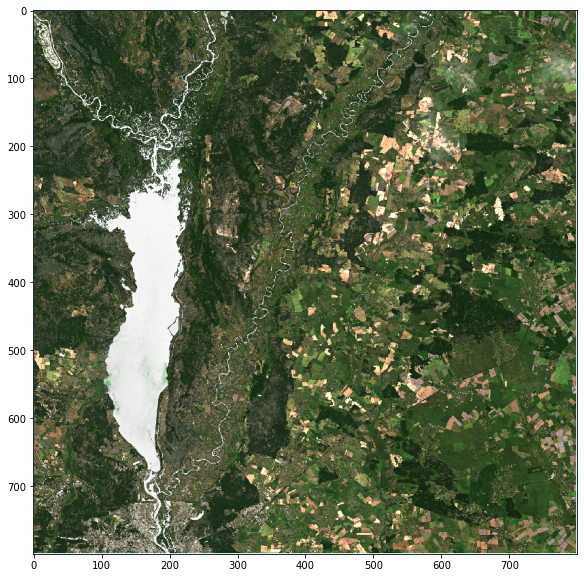

In [27]:
plt.figure(figsize=(10,10)) #задаём размеры картинки
plt.imshow(np.dstack([gdalData1.GetRasterBand(i).ReadAsArray() for i in [4,3,2,8]])*5)
#изображение для первого датасета
#выбирает определенные каналы из изображения, конвертирует в нп-массивы и собирает в один, потом отображает как изображение

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


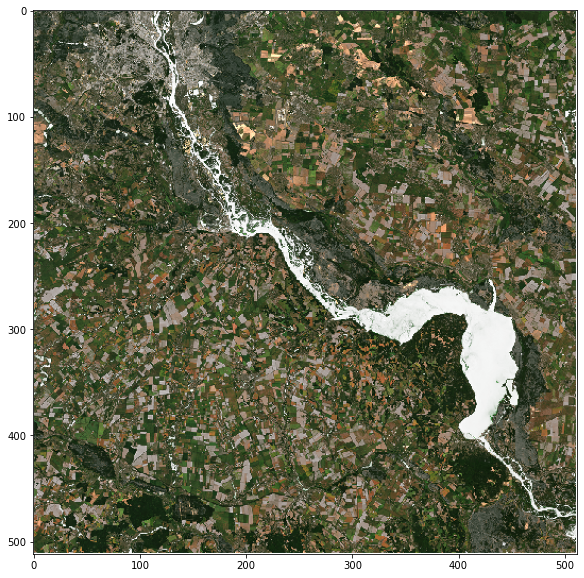

In [28]:
plt.figure(figsize=(10,10)) #задаём размеры картинки
plt.imshow(np.dstack([gdalData2.GetRasterBand(i).ReadAsArray() for i in [4,3,2,8]])*4)
#и для второго

In [16]:
#создаём виртуальный датасет,чтобы слить несколько растровых файлов в один
#по сути, мы склеиваем две картинки
vrt = gdal.BuildVRT("data/Kyiv.vrt", glob("data/*/response.tiff"))
#переводим этот датасет в формат тифф, чтобы с ним можно было работать, как с изображением, с помощью gdal
#теперь у нас есть картинка, склеенная из двух, с расширением tiff
img1 = gdal.Translate("data/Sentinel.tiff", vrt)

In [17]:
gdalData = gdal.Open("data/Sentinel.tiff")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


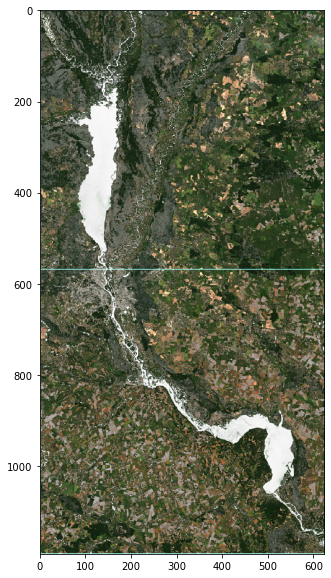

In [18]:
plt.figure(figsize=(20,10))
plt.imshow(np.dstack([gdalData.GetRasterBand(i).ReadAsArray() for i in [4,3,2,8]])*4)
#изображение для общего датасета 
#GetRasterBand - получение отдельного канала 
#gdalData.ReadAsArray() - получение всего растра целиком

In [45]:
gdalData_warped = gdal.Warp("data/gdalData_warped.tiff", gdalData, dstSRS="EPSG:4326") #перепроектируем в проекцию 4326

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


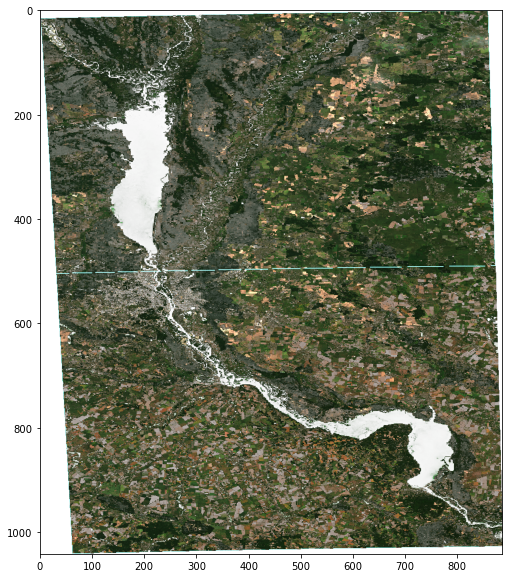

In [46]:
plt.figure(figsize=(20,10)) #задаём размеры картинки
plt.imshow(np.dstack([gdalData_warped.GetRasterBand(i).ReadAsArray() for i in [4,3,2,8]])*4)

In [56]:
gdalData_Kyiv = gdal.Warp('data/gdalData_Kyiv.tiff', gdalData_warped, cutlineDSName='data/Kyiv_regions.shp', cropToCutline=True)

In [57]:
print(gdalData_Kyiv)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000023381B07A50> >


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


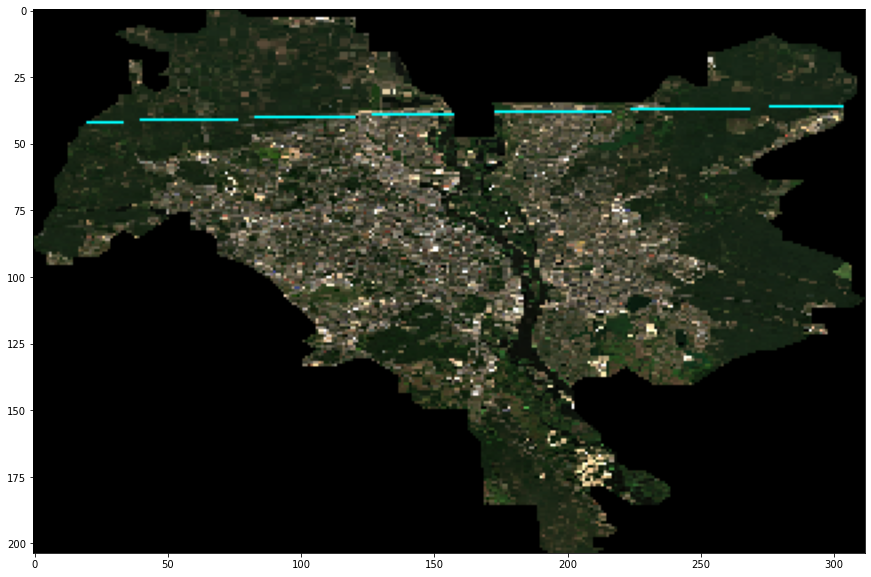

In [58]:
plt.figure(figsize=(20,10))
plt.imshow(np.dstack([gdalData_Kyiv.GetRasterBand(i).ReadAsArray() for i in [4,3,2]])*4)